# Cramér-Rao Bounds and Sparse Sensing


In [1]:
import random

import pandas as pd

from tqdm import tqdm

import numpy as np
import numpy.random as rd
from numpy import pi, exp, sin, cos

import scipy.linalg as la

import cvxpy as cp

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Seaborn Set-up
sns.set_theme(style="darkgrid")

np.set_printoptions(precision=2)


## Data Model

$$
\bm x_t = \bm A \bm s_t + \bm e_t
$$

## CRBs

Source known, no additional nuisances (noise power does not affect CRB):

$$
\frac{\sigma^2}{2T} \left( \mathrm{Re}\left\{ \bm D^H \bm D \circ \bm R^T \right\} \right)^{-1}
\\
\bm R = \frac{1}{N} \sum_{t=1}^T \bm s_t \bm s_t^H
\\
\bm D = \left[ \bm d(\omega_1), \dots, \bm d(\omega_K) \right]
\\
\bm d(\omega) = \frac{\partial \bm a(\omega)}{\partial \omega}
$$

Source unknown, RCSs are the nuisances:

$$
\frac{\sigma^2}{2T} \left( \mathrm{Re}\left\{ \bm D^H \left( \bm I - \bm A \left( \bm A^H \bm A \right)^{-1} \bm A^H \right) \bm D \circ \bm R^T \right\} \right)^{-1}
$$


## Sparse Sensing


For simplicity

$$
\bm a(\omega) = \left[ 1, e^{j\omega}, \dots, e^{j(N-1)\omega} \right]
\\
\bm d(\omega) = \left[ 0, je^{j\omega}, \dots, j(N-1)e^{j(N-1)\omega} \right]
$$

We only select $M$ samples from the $N$ available:

$$
\bm y_t = \bm \Phi(\bm w) \bm x_t
\\
\bm w \in \{ 0, 1 \}^N
\qquad
\bm 1^T \bm w = M
\\
\bm \Phi(\bm w) \bm \Phi^T(\bm w) = \bm I
\qquad
\bm \Phi^T(\bm w) \bm \Phi(\bm w) = \mathrm{diag}(\bm w)
$$


In [2]:
def generate_A(theta, N, lambda_spacing=0.5):
    return exp(
        1j * 2 * pi * lambda_spacing * np.outer(np.arange(N), np.cos(theta))
    ).squeeze()


### One-Source CRB


$$
\begin{aligned}
f_\text{known} &= \bm d^H(\omega) \bm W \bm d(\omega)
\\
&= \sum_{n=0}^{N-1} w_n n^2
\\
f_\text{unknown} &= f_\text{known} - \bm d^H(\omega) \bm W \bm a(\omega) \left( \bm a^H(\omega) \bm W \bm a(\omega) \right)^{-1} \bm a^H(\omega) \bm W \bm d(\omega)
\\
&= \sum_{n=0}^{N-1} w_n n^2 - \frac{1}{M} \left( \sum_{n=0}^{N-1} w_n n \right)^2
\\
\bm W &= \mathrm{diag}(\bm w)
\end{aligned}
$$

For $f_\text{known}$, the array should be centered (regularity conditions). The expression for $f_\text{unknown}$ is already centered.


In [3]:
def solve_single_source_selection(N_observations, M_sparsity):
    N_arange = np.arange(N_observations)

    w = cp.Variable(N_observations)

    cost = cp.Maximize(
        cp.sum(cp.multiply(w, N_arange**2))
        - ((cp.sum(cp.multiply(w, N_arange)) ** 2) / M_sparsity)
    )

    constraints = [
        w >= 0,
        w <= 1,
        cp.sum(w) == M_sparsity,
    ]

    problem = cp.Problem(cost, constraints)

    problem.solve()

    return w.value


In [4]:
N_list = [8, 16, 32, 64, 128]

for N in N_list:
    M = max(int(N / 4), 4)
    print("\nN =", N, ", M = ", M)
    w_single_value = solve_single_source_selection(N, M)
    print("w_tilde = \n", w_single_value)
    print(
        "indices of M largest values \n",
        np.sort(np.argsort(w_single_value)[-M:]),
    )



N = 8 , M =  4
w_tilde = 
 [ 1.00e+00  1.00e+00  2.60e-07  3.63e-07  2.58e-07 -2.13e-07  1.00e+00
  1.00e+00]
indices of M largest values 
 [0 1 6 7]

N = 16 , M =  4
w_tilde = 
 [1.00e+00 1.00e+00 2.64e-18 2.16e-18 1.84e-18 1.47e-18 1.23e-18 9.97e-19
 8.20e-19 6.74e-19 5.56e-19 4.63e-19 3.90e-19 3.33e-19 1.00e+00 1.00e+00]
indices of M largest values 
 [ 0  1 14 15]

N = 32 , M =  8
w_tilde = 
 [ 1.00e+00  1.00e+00  1.00e+00  1.00e+00 -1.07e-16 -9.53e-17 -8.38e-17
 -7.18e-17 -6.29e-17 -5.59e-17 -5.00e-17 -4.39e-17 -3.89e-17 -3.49e-17
 -3.10e-17 -2.77e-17 -2.49e-17 -2.23e-17 -2.01e-17 -1.82e-17 -1.65e-17
 -1.50e-17 -1.36e-17 -1.25e-17 -1.15e-17 -1.06e-17 -9.80e-18 -9.10e-18
  1.00e+00  1.00e+00  1.00e+00  1.00e+00]
indices of M largest values 
 [ 0  1  2  3 28 29 30 31]

N = 64 , M =  16
w_tilde = 
 [1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 4.44e-17 3.95e-17 3.55e-17 3.23e-17 2.96e-17 2.73e-17 2.54e-17 2.37e-17
 2.21e-17 2.04e-17 1.88e-17 1.75e-17 1.63e

### Two-Source CRB


$$
\bm F_\text{known} = \bm D^H \bm W \bm D \circ \bm R^T
\\
\bm F_\text{unknown} = \bm D^H \bm W \bm D \circ \bm R^T - \bm D^H \bm W \bm A \left( \bm A^H \bm W \bm A \right)^{-1} \bm A^H \bm W \bm D \circ \bm R^T
$$


#### For Uncorrelated Equal-Power Sources


If we assume the sources uncorrelated and of equal power, then $\bm R = \alpha \bm I$

Some notation for convenience:

$$
z = \sum_{n=0}^{N-1} w_n
\qquad
z(\Delta\omega) = \sum_{n=0}^{N-1} w_n e^{jn\Delta\omega}
\\
\bar z = \sum_{n=0}^{N-1} w_n n
\qquad
\bar z(\Delta\omega) = \sum_{n=0}^{N-1} w_n n e^{jn\Delta\omega}
\\
\bar{\bar z} = \sum_{n=0}^{N-1} w_n n^2
% \qquad
% \bar{\bar{z}}(\Delta\omega) = \sum_{n=0}^{N-1} w_n n^2 e^{jn\Delta\omega}
\\
\bm Z(\Delta\omega) = \begin{bmatrix}
  z & z(\Delta\omega)
  \\
  z^*(\Delta\omega) & z
\end{bmatrix}
\qquad
\bar{\bm z}(\Delta\omega) = \begin{bmatrix} \bar z & \bar z^*(\Delta\omega) \end{bmatrix}^T
$$

The cost function to maximize is

$$
\begin{aligned}
  f_{k,\text{unknown}} &= \bm d^H(\omega_k) \bm W \bm d(\omega_k) - \bm d^H(\omega_k) \bm W \bm A \left( \bm A^H \bm W \bm A \right)^{-1} \bm A^H \bm W \bm d(\omega_k)
  \\
  &= \bar{\bar{z}} - \bar{\bm z}_k^H(\Delta\omega) \bm Z^{-1}(\Delta\omega) \bar{\bm z}_k(\Delta\omega)
\end{aligned}
$$

Using the expression for known $\bm s$ simplifies to the single source case.


In [5]:
def get_positive_delta_omega_grid(N, start=None, stop=pi):
    first_null = 2 * 0.886 / N
    if start is None:
        start = first_null
    else:
        start = max(start, first_null)
    return np.linspace(start, stop, 128)


In [6]:
def CRB(w, delta_omega):
    N = len(w)
    N_arange = np.arange(N)

    z = np.sum(w)
    z_bar = np.sum(w * N_arange)
    z_double_bar = np.sum(w * (N_arange**2))

    exp_j_n_delta_omega = exp(1j * N_arange * delta_omega)

    z_delta_omega = np.sum(w * exp_j_n_delta_omega)

    z_bar_delta_omega = np.sum(w * N_arange * exp_j_n_delta_omega)
    z_bar_delta_omega = np.array([z_bar, np.conj(z_bar_delta_omega)]).reshape(
        2, 1
    )

    Z_delta_omega = np.array(
        [
            [z, z_delta_omega],
            [np.conj(z_delta_omega), z],
        ]
    )

    try:
        return 1 / np.real(
            z_double_bar
            - (
                z_bar_delta_omega.conj().T
                @ la.inv(Z_delta_omega)
                @ z_bar_delta_omega
            ).squeeze()
        )
    except la.LinAlgError:
        return np.inf


def worst_CRB(w, delta_omega_grid=None):
    N = len(w)

    if delta_omega_grid is None:
        delta_omega_grid = get_positive_delta_omega_grid(N)

    worst_result = 0
    for delta_omega in delta_omega_grid:
        result = CRB(w, delta_omega)
        if result > worst_result:
            worst_result = result

    return worst_result


def round_by_sorting(vector, number_of_ones):
    argument = np.argsort(vector)[-number_of_ones:]
    output = np.zeros_like(vector)
    output[argument] = 1
    return output


def array_selection(w, omega):
    A = generate_A(omega, len(w))
    selection = A * w
    return selection.squeeze()


def randomized_rounding(vector, M, full_aperture=True):
    result = np.zeros_like(vector)
    indices = list(range(len(vector)))

    if full_aperture:
        result[0] = result[-1] = 1
        del indices[0]
        del indices[-1]

    while np.sum(result) < M:
        i_index = random.randrange(0, len(indices), 1)
        index = indices[i_index]
        result[index] = int(random.uniform(0, 1) < vector[index])
        if result[index] == 1:
            del indices[i_index]

    return result


def pick_best_from_random_rounding(vector, M, attempts=100, grid=None):
    if grid is None:
        grid = get_positive_delta_omega_grid(len(vector))

    best = np.inf
    best_result = np.zeros_like(vector)

    for i in range(attempts):
        result = randomized_rounding(vector, M)
        result_CRB = worst_CRB(result, delta_omega_grid=grid)
        if result_CRB < best:
            best = result_CRB
            best_result = result

    return best_result


In [7]:
def grid_point_constraint(w, g, N, delta_omega):
    K_sources = 2
    N_arange = np.arange(N)
    exp_j_n_delta_omega = exp(1j * N_arange * delta_omega)

    z = cp.sum(w)
    z_bar = cp.sum(cp.multiply(w, N_arange))

    z_bar_delta_omega_scalar = cp.sum(
        cp.multiply(w, N_arange * exp_j_n_delta_omega)
    )

    z_bar_delta_omega_vector = cp.reshape(
        cp.hstack(
            [
                z_bar,
                cp.conj(z_bar_delta_omega_scalar),
            ]
        ),
        (K_sources, 1),
    )

    z_delta_omega = cp.sum(cp.multiply(w, exp_j_n_delta_omega))

    Z = cp.bmat([[z, z_delta_omega], [cp.conj(z_delta_omega), z]])

    psd_matrix = cp.bmat(
        [
            [cp.reshape(g, (1, 1)), z_bar_delta_omega_vector.H],
            [z_bar_delta_omega_vector, Z],
        ]
    )

    real_psd_matrix = cp.bmat(
        [
            [cp.real(psd_matrix), -cp.imag(psd_matrix)],
            [cp.imag(psd_matrix), cp.real(psd_matrix)],
        ]
    )

    return [
        real_psd_matrix >> 0,
    ]


In [8]:
def solve_two_source_selection(
    N_observations, M_sparsity, delta_omega_grid=None
):
    w_passive = cp.Variable(N_observations)
    c_passive = cp.Variable()
    g_passive = cp.Variable()

    N_arange = np.arange(N_observations)

    if delta_omega_grid is None:
        delta_omega_grid = get_positive_delta_omega_grid(N_observations)

    z = cp.sum(w_passive)
    z_bar = cp.sum(cp.multiply(w_passive, N_arange))
    z_double_bar = cp.sum(cp.multiply(w_passive, N_arange**2))

    cost_passive = cp.Minimize(c_passive)

    constraints_passive = [
        w_passive >= 0,
        w_passive <= 1,
        cp.sum(w_passive) == M_sparsity,
        cp.bmat(
            [
                [z_double_bar - g_passive, 1],
                [1, c_passive],
            ]
        )
        >> 0,
    ]

    for delta_omega in delta_omega_grid:
        constraints_passive += grid_point_constraint(
            w_passive, g_passive, N_observations, delta_omega
        )

    problem_passive = cp.Problem(cost_passive, constraints_passive)
    problem_passive.solve(
        solver=cp.CVXOPT, max_iters=2500, refinement=10, kktsolver="robust"
    )

    return w_passive.value


In [9]:
for N in N_list:
    M = max(int(N / 4), 4)

    print("N =", N, ", M = ", M)

    w_passive_value = solve_two_source_selection(N, M)

    print("w_tilde = \n", w_passive_value)
    print(
        "indices of M largest values \n",
        np.sort(
            np.argsort(pick_best_from_random_rounding(w_passive_value, M))[-M:]
        ),
        "\n",
    )


N = 8 , M =  4
w_tilde = 
 [1.00e+00 2.07e-09 1.67e-08 1.00e+00 1.00e+00 4.03e-10 2.74e-10 1.00e+00]
indices of M largest values 
 [0 3 4 7] 

N = 16 , M =  4
w_tilde = 
 [1.00e+00 1.73e-09 7.55e-10 7.40e-10 1.01e-09 2.35e-09 1.46e-08 1.00e+00
 1.00e+00 8.43e-09 1.67e-09 8.64e-10 6.21e-10 5.83e-10 8.81e-10 1.00e+00]
indices of M largest values 
 [ 0  7  8 15] 

N = 32 , M =  8
w_tilde = 
 [1.00e+00 1.00e+00 1.47e-07 6.12e-08 4.94e-08 4.62e-08 4.75e-08 5.25e-08
 6.22e-08 7.97e-08 1.14e-07 1.90e-07 3.53e-07 3.89e-05 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.18e-05 3.72e-07 1.68e-07 1.04e-07 7.49e-08 5.91e-08
 5.02e-08 4.56e-08 4.44e-08 4.72e-08 5.77e-08 9.59e-08 1.00e+00 1.00e+00]
indices of M largest values 
 [ 0  1 14 15 16 17 30 31] 

N = 64 , M =  16
w_tilde = 
 [1.00e+00 1.00e+00 1.00e+00 8.42e-01 2.96e-06 1.40e-06 1.00e-06 8.28e-07
 7.33e-07 6.80e-07 6.52e-07 6.42e-07 6.47e-07 6.64e-07 6.94e-07 7.37e-07
 7.97e-07 8.77e-07 9.84e-07 1.13e-06 1.33e-06 1.61e-06 2.02e-06 2.69e-06
 3.95e-06

In [10]:
N = 64
M = max(int(N / 4), 4)

print("N =", N, ", M = ", M)

delta_omega_grid = get_positive_delta_omega_grid(N, start=pi / 18)

w_passive_value = solve_two_source_selection(
    N, M, delta_omega_grid=delta_omega_grid
)

print("w_tilde = \n", w_passive_value)
print(
    "indices of M largest values \n",
    np.sort(
        np.argsort(
            pick_best_from_random_rounding(
                w_passive_value, M, grid=delta_omega_grid, attempts=1000
            )
        )[-M:]
    ),
    "\n",
)


N = 64 , M =  16
w_tilde = 
 [1.00e+00 1.00e+00 1.00e+00 2.25e-01 6.99e-04 7.25e-04 1.27e-03 3.07e-03
 4.67e-01 6.83e-01 9.13e-02 7.88e-02 1.41e-01 3.63e-01 6.21e-01 6.11e-01
 1.61e-01 6.29e-02 4.84e-01 9.85e-01 2.16e-02 1.13e-03 3.35e-04 1.51e-04
 8.54e-05 5.60e-05 4.09e-05 3.25e-05 2.76e-05 2.47e-05 2.30e-05 2.23e-05
 2.24e-05 2.33e-05 2.51e-05 2.83e-05 3.36e-05 4.27e-05 5.91e-05 9.16e-05
 1.65e-04 3.74e-04 1.39e-03 1.39e-02 9.79e-01 5.05e-01 5.61e-02 1.57e-01
 6.28e-01 6.23e-01 3.32e-01 1.50e-01 9.57e-02 1.11e-01 6.13e-01 4.99e-01
 8.01e-03 8.37e-04 5.15e-04 4.41e-04 2.20e-01 1.00e+00 1.00e+00 1.00e+00]
indices of M largest values 
 [ 0  1  2  6  9 12 14 16 44 45 48 49 54 61 62 63] 



## Example beampatterns


In [11]:
N_observations = 24
M_sparsity = int(N_observations / 4)


w_single = round_by_sorting(
    solve_single_source_selection(N_observations, M_sparsity), M_sparsity
)

w_double = round_by_sorting(
    solve_two_source_selection(N_observations, M_sparsity), M_sparsity
)


In [12]:
scanning_angles = np.linspace(0, pi, 721)
beampattern_scanner = generate_A(scanning_angles, N_observations)


In [13]:
def random_selection(N, M):
    output = np.zeros(N)
    while np.sum(output) < M:
        output[random.randint(0, N - 1)] = 1

    return output


N_random = 100

random_beampattern = np.zeros_like(scanning_angles)
for i in range(N_random):
    random_beampattern += np.abs(
        beampattern_scanner.conj().T
        @ array_selection(
            random_selection(N_observations, M_sparsity), 0.5 * pi
        )
    )

random_beampattern = random_beampattern / (M_sparsity * N_random)


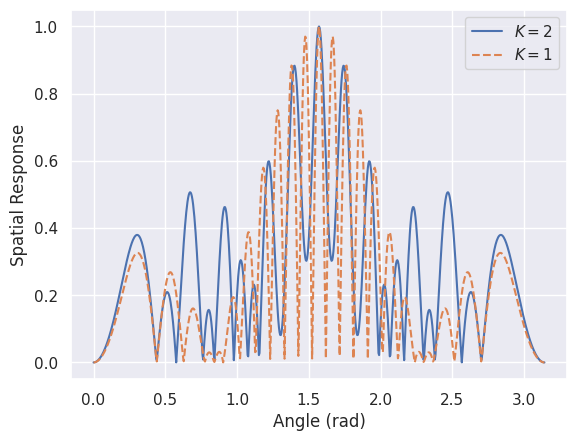

In [14]:
a_single = array_selection(w_single, 0.5 * pi)
a_double = array_selection(w_double, 0.5 * pi)


_, axs = plt.subplots(1, 1)

axs.plot(
    scanning_angles,
    np.abs(beampattern_scanner.conj().T @ a_double) / M_sparsity,
    label="$K=2$",
)

axs.plot(
    scanning_angles,
    np.abs(beampattern_scanner.conj().T @ a_single) / M_sparsity,
    label="$K=1$",
    linestyle="dashed",
)

axs.set_ylabel("Spatial Response")
axs.set_xlabel("Angle (rad)")

axs.legend()


## CRB Plots


In [15]:
number_of_trials = 100

N_list = np.arange(int((128 - 16 + 8) / 8)) * 8 + 16
N_data = pd.DataFrame()

for N in tqdm(N_list):
    M = int(N / 4)

    w_single = solve_single_source_selection(N, M)
    w_double = solve_two_source_selection(N, M)

    for trial in range(number_of_trials):
        rounded_double = randomized_rounding(w_double, M)
        rounded_single = randomized_rounding(w_single, M)
        random_select = random_selection(N, M)

        new_rounding_data = pd.DataFrame(
            [
                [
                    "double",
                    N,
                    M,
                    int(np.sum(rounded_double)),
                    worst_CRB(rounded_double),
                    rounded_double,
                    w_double,
                ],
                [
                    "single",
                    N,
                    M,
                    int(np.sum(rounded_single)),
                    worst_CRB(rounded_single),
                    rounded_single,
                    w_single,
                ],
            ],
            columns=["type", "N", "M", "M_actual", "CRB", "w", "w_tilde"],
        )

        new_random_data = pd.DataFrame(
            [
                [
                    "random",
                    N,
                    M,
                    int(np.sum(random_select)),
                    worst_CRB(random_select),
                    random_select,
                ]
            ],
            columns=["type", "N", "M", "M_actual", "CRB", "w"],
        )

        N_data = pd.concat(
            [N_data, new_rounding_data, new_random_data], ignore_index=True
        )


100%|██████████| 15/15 [33:50<00:00, 135.39s/it]


In [16]:
M_list = np.arange(4, 96 + 4, 4)
M_data = pd.DataFrame()
N = 128

for M in tqdm(M_list):

    w_single = solve_single_source_selection(N, M)
    w_double = solve_two_source_selection(N, M)

    for trial in range(number_of_trials):
        rounded_double = randomized_rounding(w_double, M)
        rounded_single = randomized_rounding(w_single, M)
        random_select = random_selection(N, M)

        new_rounding_data = pd.DataFrame(
            [
                [
                    "double",
                    N,
                    M,
                    int(np.sum(rounded_double)),
                    worst_CRB(rounded_double),
                    rounded_double,
                    w_double,
                ],
                [
                    "single",
                    N,
                    M,
                    int(np.sum(rounded_single)),
                    worst_CRB(rounded_single),
                    rounded_single,
                    w_single,
                ],
            ],
            columns=["type", "N", "M", "M_actual", "CRB", "w", "w_tilde"],
        )

        new_random_data = pd.DataFrame(
            [
                [
                    "random",
                    N,
                    M,
                    int(np.sum(random_select)),
                    worst_CRB(random_select),
                    random_select,
                ]
            ],
            columns=["type", "N", "M", "M_actual", "CRB", "w"],
        )

        M_data = pd.concat(
            [M_data, new_rounding_data, new_random_data], ignore_index=True
        )


100%|██████████| 24/24 [34:54<00:00, 87.28s/it]


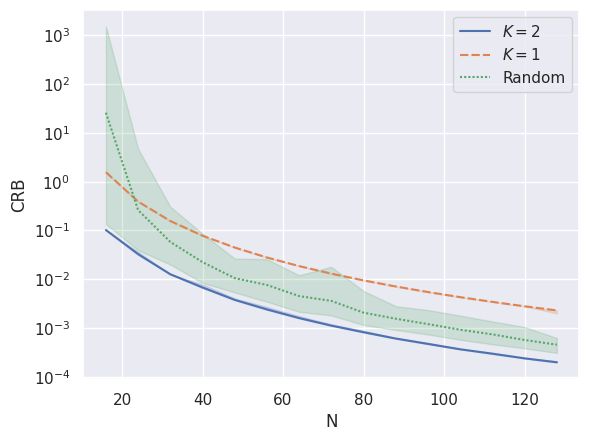

In [17]:
_, axs = plt.subplots(1, 1)

sns.lineplot(
    x="N",
    y="CRB",
    hue="type",
    style="type",
    data=N_data,
    ax=axs,
    errorbar=lambda x: (np.min(x), np.max(x)),
)
axs.set_yscale("log")

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles=handles, labels=["$K=2$", "$K=1$", "Random"])


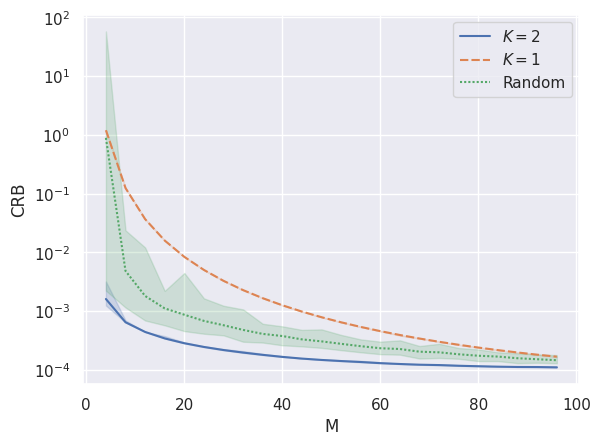

In [18]:
_, axs = plt.subplots(1, 1)

sns.lineplot(
    x="M",
    y="CRB",
    hue="type",
    style="type",
    data=M_data,
    ax=axs,
    errorbar=lambda x: (np.min(x), np.max(x)),
)
axs.set_yscale("log")

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles=handles, labels=["$K=2$", "$K=1$", "Random"])
